In [1]:
import pandas as pd
import numpy as np

In [22]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression

In [3]:
file_path = r'data_output\df_lav1.csv'
df_lav1 = pd.read_csv(file_path)

In [4]:
df_lav1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104368 entries, 0 to 104367
Data columns (total 14 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            104368 non-null  int64  
 1   Anag_oc_sintesi_progetto              104368 non-null  object 
 2   Prog_OC_COD_CATEGORIA_SPESA           104368 non-null  object 
 3   Altr_CUP_COD_NATURA                   104368 non-null  int64  
 4   Altr_CUP_COD_SETTORE                  104368 non-null  int64  
 5   Altr_OC_COD_TIPO_AIUTO                104368 non-null  object 
 6   Sogg_OC_DENOM_PROGRAMMATORE           104368 non-null  object 
 7   Sogg_OC_DESCR_FORMA_GIU_BENEFICIARIO  104237 non-null  object 
 8   New_prj_duration_pred                 104368 non-null  int64  
 9   New_marginal_cost                     104368 non-null  float64
 10  New_DEN_REGIONE_new                   104368 non-null  object 
 11  

In [5]:
df_lav1 = df_lav1.drop(columns=["Unnamed: 0","New_DEN_PROVINCIA_new", "New_marginal_cost", "Altr_CUP_COD_NATURA", "Altr_CUP_COD_SETTORE","New_DEN_COMUNE_new"])

In [6]:
#categorical_columns_to_force = ['Altr_CUP_COD_NATURA', 'Altr_CUP_COD_SETTORE', 'New_Risk']
categorical_columns_to_force = ['New_Risk']

df_lav1[categorical_columns_to_force] = df_lav1[categorical_columns_to_force].astype('category')

In [7]:
# Identifica i tipi di colonne
text_cols = ['Anag_oc_sintesi_progetto', 'Sogg_OC_DESCR_FORMA_GIU_BENEFICIARIO','Sogg_OC_DENOM_PROGRAMMATORE']
numeric_cols = ['New_prj_duration_pred', 'New_marginal_cost']
#categorical_cols = list(set(X.columns) - set(text_cols) - set(numeric_cols))
categorical_cols = list(set(df_lav1.columns) - set(numeric_cols)-set(text_cols))

In [8]:
nan_or_empty = df_lav1[text_cols].apply(lambda col: col.isna() | col.str.strip().eq(""))
df_lav1 = df_lav1[~nan_or_empty.any(axis=1)].copy()

### Dont consider invalid string for project description
We consider that project description is an important features (confirmed by feature importance permutation) so because we have a big dataset we
consider dont loosing information if we don consider rows with invalid string for project description, we made this applying the following funcion.
From the following code we see that we have about 15 k record dont acceptable but all in class 0 --- the most unbalaced, so we accept to delete.

In [10]:
import re

# Funzione per identificare stringhe non accettabili
def is_invalid_string(text):
    if pd.isna(text):  # Controllo per NaN
        return True
    text = text.strip()  # Rimuove spazi iniziali e finali
    # Controlla se il testo è vuoto, troppo corto o ha solo caratteri non significativi
    return len(text) < 4 or re.fullmatch(r"[.]+", text) is not None

# Applica il filtro alla colonna 'Anag_oc_sintesi_progetto'
invalid_rows = df_lav1["Anag_oc_sintesi_progetto"].apply(is_invalid_string)

# Seleziona i record con stringhe non accettabili
invalid_records = df_lav1[invalid_rows]

# Conta il numero di categorie target impattate
categories_impacted = invalid_records["New_Risk"].nunique()  # Sostituisci 'target' con il nome della tua colonna target

# Conta le occorrenze per ogni categoria
categories_count = invalid_records["New_Risk"].value_counts()

# Stampa i risultati
print("Record con stringhe non accettabili nella colonna 'Anag_oc_sintesi_progetto':")
print(invalid_records)
print(f"Numero di record con stringhe non accettabili: {len(invalid_records)}")
print(f"Numero di categorie target impattate: {categories_impacted}")
print("Conteggio dei record impattati per categoria target:")
print(categories_count)

Record con stringhe non accettabili nella colonna 'Anag_oc_sintesi_progetto':
      Anag_oc_sintesi_progetto Prog_OC_COD_CATEGORIA_SPESA  \
3116                       M+M                         055   
5275                       XXX                         001   
33996                     ....                         051   
33997                     ....                         051   
33998                     ....                         051   
...                        ...                         ...   
74133                       SA                         067   
74218                       SS                         067   
75066                        G                         067   
77531                        N                         067   
85214                      VGM                         067   

      Altr_OC_COD_TIPO_AIUTO Sogg_OC_DENOM_PROGRAMMATORE  \
3116                       F             REGIONE TOSCANA   
5275                       D             REGIONE TOSCANA 

In [11]:
df_lav1 = df_lav1[~invalid_rows]

In [12]:
df_lav1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88846 entries, 0 to 104367
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   Anag_oc_sintesi_progetto              88846 non-null  object  
 1   Prog_OC_COD_CATEGORIA_SPESA           88846 non-null  object  
 2   Altr_OC_COD_TIPO_AIUTO                88846 non-null  object  
 3   Sogg_OC_DENOM_PROGRAMMATORE           88846 non-null  object  
 4   Sogg_OC_DESCR_FORMA_GIU_BENEFICIARIO  88846 non-null  object  
 5   New_prj_duration_pred                 88846 non-null  int64   
 6   New_DEN_REGIONE_new                   88846 non-null  object  
 7   New_Risk                              88846 non-null  category
dtypes: category(1), int64(1), object(6)
memory usage: 5.5+ MB


In [13]:
X = df_lav1.drop('New_Risk', axis=1)
y = df_lav1['New_Risk']

In [14]:
# repeat it here to apply on the X with no target in
text_cols = ['Anag_oc_sintesi_progetto', 'Sogg_OC_DESCR_FORMA_GIU_BENEFICIARIO','Sogg_OC_DENOM_PROGRAMMATORE']
numeric_cols = ['New_prj_duration_pred']
#categorical_cols = list(set(X.columns) - set(text_cols) - set(numeric_cols))
categorical_cols = list(set(X.columns) - set(numeric_cols)-set(text_cols))

In [15]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88846 entries, 0 to 104367
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   Anag_oc_sintesi_progetto              88846 non-null  object
 1   Prog_OC_COD_CATEGORIA_SPESA           88846 non-null  object
 2   Altr_OC_COD_TIPO_AIUTO                88846 non-null  object
 3   Sogg_OC_DENOM_PROGRAMMATORE           88846 non-null  object
 4   Sogg_OC_DESCR_FORMA_GIU_BENEFICIARIO  88846 non-null  object
 5   New_prj_duration_pred                 88846 non-null  int64 
 6   New_DEN_REGIONE_new                   88846 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.4+ MB


### Preprocessing

In [16]:
text_transformers = ColumnTransformer(
    transformers=[
        ('text1', TfidfVectorizer(), 'Anag_oc_sintesi_progetto'),
        ('text2', TfidfVectorizer(), 'Sogg_OC_DESCR_FORMA_GIU_BENEFICIARIO'),
        ('text3', TfidfVectorizer(), 'Sogg_OC_DENOM_PROGRAMMATORE')
    ],
    remainder='passthrough'  # Keep numeric and categorical data untouched
)

# Preprocessor for numeric and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ],
    remainder='drop'  # Drop columns not explicitly mentioned
)

# Combine preprocessing for numeric/categorical and text columns
final_preprocessor = ColumnTransformer(
    transformers=[
        ('num_cat', preprocessor, numeric_cols + categorical_cols),
        ('text', text_transformers, text_cols),
    ],
    remainder='drop'  # Drop other columns
)

In [17]:
#y.info()

In [18]:


# all X and y
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [19]:
#y_train.info()

In [20]:
#X_train.head(50)

# Apply LR Model with:
- weight balancing: function of frequences
- thresholds = {0: 0.65, 1: 0.3, 2: 0.3, 3: 0.45} -- selected after several test


________________________________________________________________________________
[Memory] Calling imblearn.pipeline._fit_transform_one...
_fit_transform_one(ColumnTransformer(transformers=[('num_cat',
                                 ColumnTransformer(transformers=[('num',
                                                                  StandardScaler(),
                                                                  ['New_prj_duration_pred']),
                                                                 ('cat',
                                                                  OneHotEncoder(handle_unknown='ignore'),
                                                                  ['New_DEN_REGIONE_new',
                                                                   'Altr_OC_COD_TIPO_AIUTO',
                                           ..., 
                                 Anag_oc_sintesi_progetto  \
100216  PROGETTO DI EFFICIENTAMENTO ENERGETICO DEI SEG...   
9901    IL PROG

C:\Users\gsepe\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


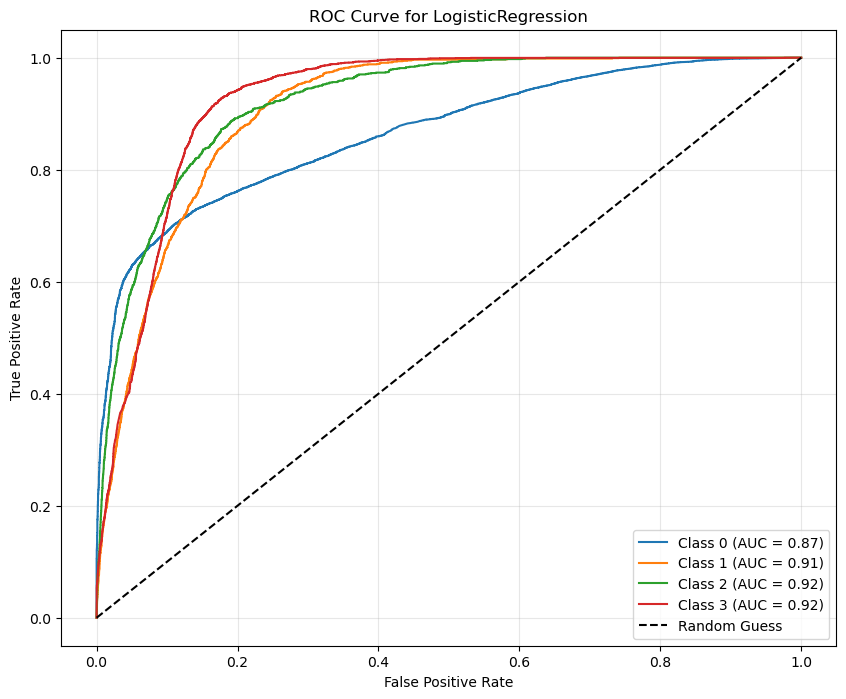

Model: LogisticRegression
  F1 Score (macro): 0.5431
  Precision (macro): 0.4975
  Recall (macro): 0.6601
  Accuracy: 0.7197
  Confusion Matrix:
[[15142  1811  1220  2536]
 [  268   677   478    21]
 [  204   162   818    57]
 [  513    47   153  2547]]
  Best Params: {'classifier__C': 1, 'classifier__solver': 'liblinear'}
--------------------------------------------------
  Metrics per Class:
    Class 0: Precision: 0.9389, Recall: 0.7312, F1-Score: 0.8221, Support: 20709.0
    Class 1: Precision: 0.2510, Recall: 0.4688, F1-Score: 0.3270, Support: 1444.0
    Class 2: Precision: 0.3065, Recall: 0.6591, F1-Score: 0.4184, Support: 1241.0
    Class 3: Precision: 0.4935, Recall: 0.7813, F1-Score: 0.6049, Support: 3260.0
--------------------------------------------------
  ROC AUC per Class:
    Class 0: AUC = 0.8654
    Class 1: AUC = 0.9082
    Class 2: AUC = 0.9222
    Class 3: AUC = 0.9249


In [23]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
)
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

from joblib import Memory


# Logistic Regression e parametri

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights_dict = {i: weight for i, weight in enumerate(class_weights)}

models = {
    "LogisticRegression": LogisticRegression(random_state=42, multi_class="ovr",class_weight=weights_dict),
}

param_grids = {
    "LogisticRegression": {
        "classifier__solver": ["liblinear", "saga", "lbfgs"],
        "classifier__C": [0.01, 0.1, 1, 10, 100],  # Regolarizzazione inversa
    },
}

# Store results
results = []
thresholds = {0: 0.65, 1: 0.3, 2: 0.3, 3: 0.45}  # Soglie personalizzate per ogni classe

for model_name, model in models.items():
    # Creazione Pipeline con RandomUnderSampler
    cachedir = 'cache_directory'
    memory = Memory(cachedir, verbose=10)
    
    pipeline = ImbPipeline(
        steps=[
            ("preprocessor", final_preprocessor),  # Definisci questo preprocessore
#            ("undersampler", RandomUnderSampler(random_state=42)),
            ("classifier", model),
        ], memory=memory
    )

    # GridSearchCV per iperparametri
    grid_search = GridSearchCV(
        pipeline, param_grids[model_name], cv=5, scoring="f1_macro", n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    # Best model
    best_model = grid_search.best_estimator_

    # Probabilità previste
    y_proba = best_model.predict_proba(X_test)

    # Applica soglie personalizzate
    y_pred_custom = np.zeros_like(y_test)
    for i, threshold in thresholds.items():
        y_pred_custom[y_proba[:, i] >= threshold] = i

    # Metriche globali
    f1 = f1_score(y_test, y_pred_custom, average="macro")
    precision = precision_score(y_test, y_pred_custom, average="macro")
    recall = recall_score(y_test, y_pred_custom, average="macro")
    accuracy = accuracy_score(y_test, y_pred_custom)
    conf_matrix = confusion_matrix(y_test, y_pred_custom)

    # Metriche per ciascuna classe
    class_report = classification_report(y_test, y_pred_custom, output_dict=True)

    # Calcolo ROC e AUC
    n_classes = len(np.unique(y_test))  # Numero di classi
    y_test_binary = label_binarize(y_test, classes=np.arange(n_classes))

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], y_proba[:, i])
        roc_auc[i] = roc_auc_score(y_test_binary[:, i], y_proba[:, i])

    # Grafico delle curve ROC
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

    # Linea casuale per riferimento
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

    plt.title(f"ROC Curve for {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

    # Store results
    results.append({
        "Model": model_name,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall,
        "Accuracy": accuracy,
        "Confusion Matrix": conf_matrix,
        "Best Params": grid_search.best_params_,
        "Class Report": class_report,
        "ROC AUC": roc_auc,
    })

# Display results
for result in results:
    print(f"Model: {result['Model']}")
    print(f"  F1 Score (macro): {result['F1 Score']:.4f}")
    print(f"  Precision (macro): {result['Precision']:.4f}")
    print(f"  Recall (macro): {result['Recall']:.4f}")
    print(f"  Accuracy: {result['Accuracy']:.4f}")
    print(f"  Confusion Matrix:\n{result['Confusion Matrix']}")
    print(f"  Best Params: {result['Best Params']}")
    print("-" * 50)
    print("  Metrics per Class:")
    for class_id, metrics in result["Class Report"].items():
        if class_id.isdigit():  # Filtra solo le classi numeriche
            print(f"    Class {class_id}: Precision: {metrics['precision']:.4f}, "
                  f"Recall: {metrics['recall']:.4f}, F1-Score: {metrics['f1-score']:.4f}, "
                  f"Support: {metrics['support']}")
    print("-" * 50)

    print("  ROC AUC per Class:")
    for class_id, auc in result["ROC AUC"].items():
        print(f"    Class {class_id}: AUC = {auc:.4f}")


In [24]:
# picking results for linear regression:
import joblib
results_bm = grid_search.best_estimator_

joblib.dump(results, r"data_output\Lav_1_work_3.3-LR_W.pkl")
joblib.dump(results_bm, r"data_output\Lav_1_work_3.3-LR_W_BM.pkl")

['data_output\\Lav_1_work_3.3-LR_W_BM.pkl']

# Feature permutation importance

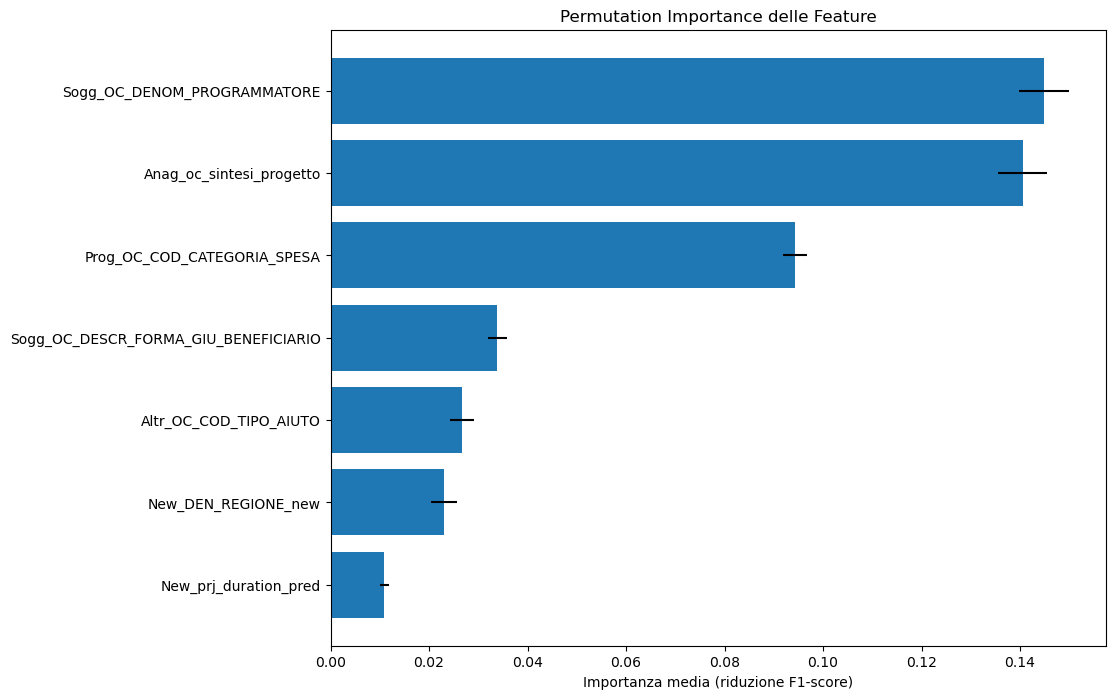

In [28]:

# Calcolo della Permutation Importance sul modello migliore
perm_importance = permutation_importance(
    best_model,  # Modello già addestrato
    X_test,      # Feature di test
    y_test,      # Target di test
    scoring="f1_macro",  # Metriche basate su F1 macro
    random_state=42,
    n_repeats=10  # Numero di ripetizioni per robustezza
)

# Estrai risultati
feature_names = X_test.columns  # Assicurati che X_test sia un DataFrame
importances = perm_importance.importances_mean  # Importanza media per ogni feature
std = perm_importance.importances_std          # Deviazione standard delle importanze

# Ordina le feature per importanza
sorted_idx = np.argsort(importances)[::-1]  # Ordine decrescente

# Grafico dell'importanza delle feature
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], xerr=std[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.gca().invert_yaxis()  # Inverto l'asse per mostrare le più importanti in alto
plt.title("Permutation Importance delle Feature")
plt.xlabel("Importanza media (riduzione F1-score)")
plt.savefig(f"img/Permutation_Importance_Media.png")
plt.show()


Calcolo Permutation Importance per Classe 0


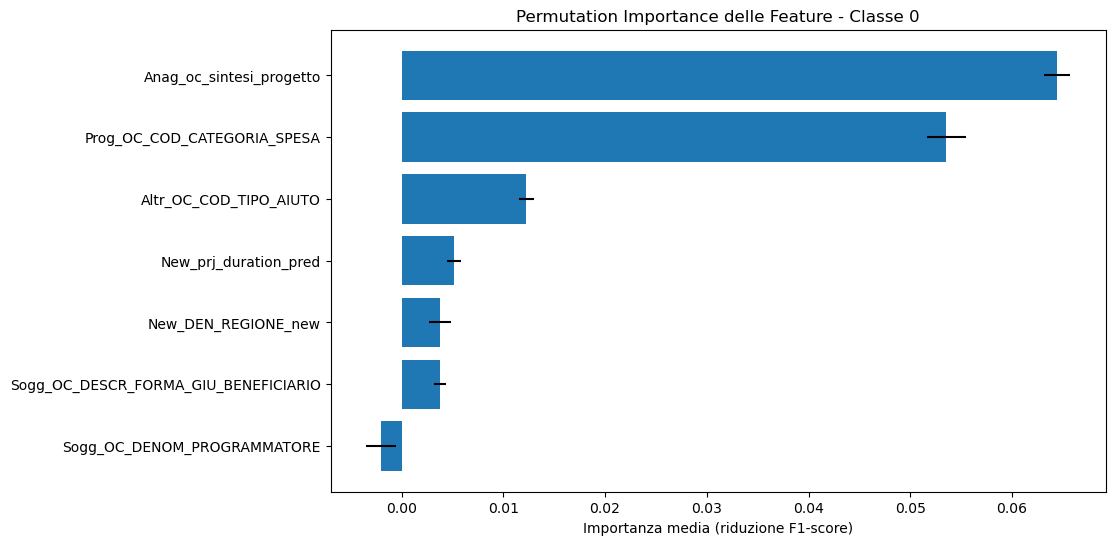

Calcolo Permutation Importance per Classe 1


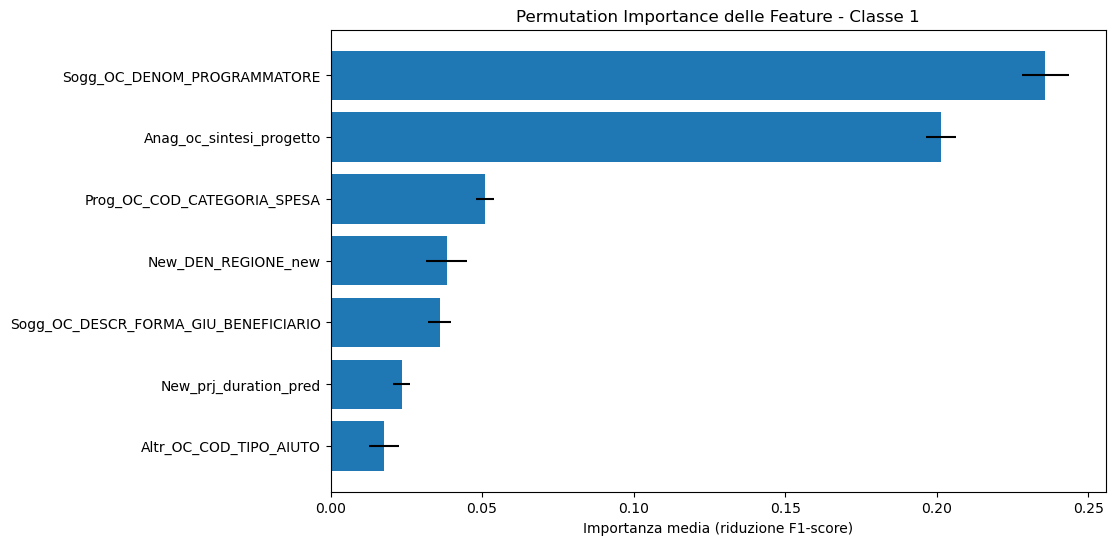

Calcolo Permutation Importance per Classe 2


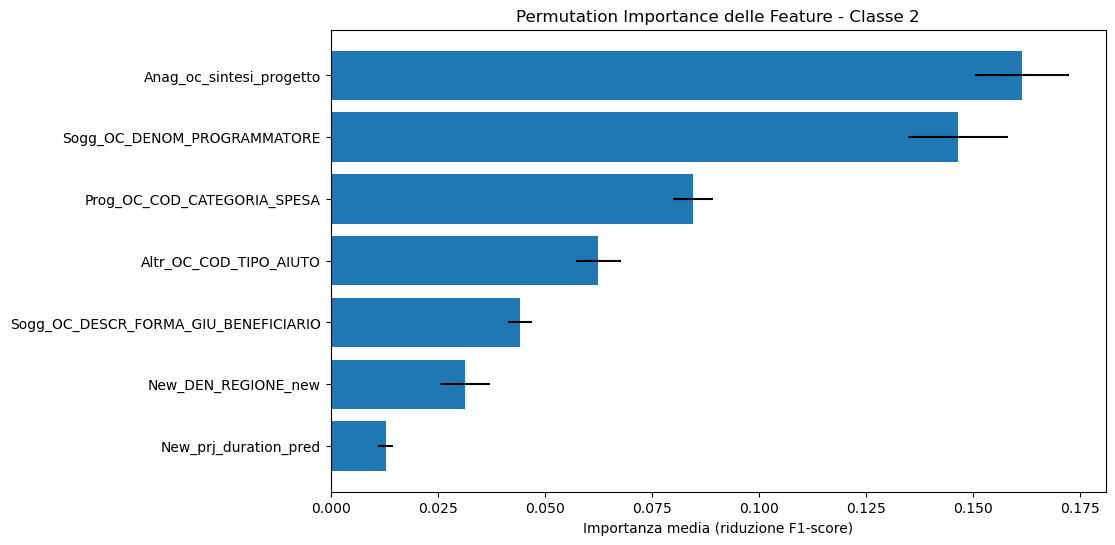

Calcolo Permutation Importance per Classe 3


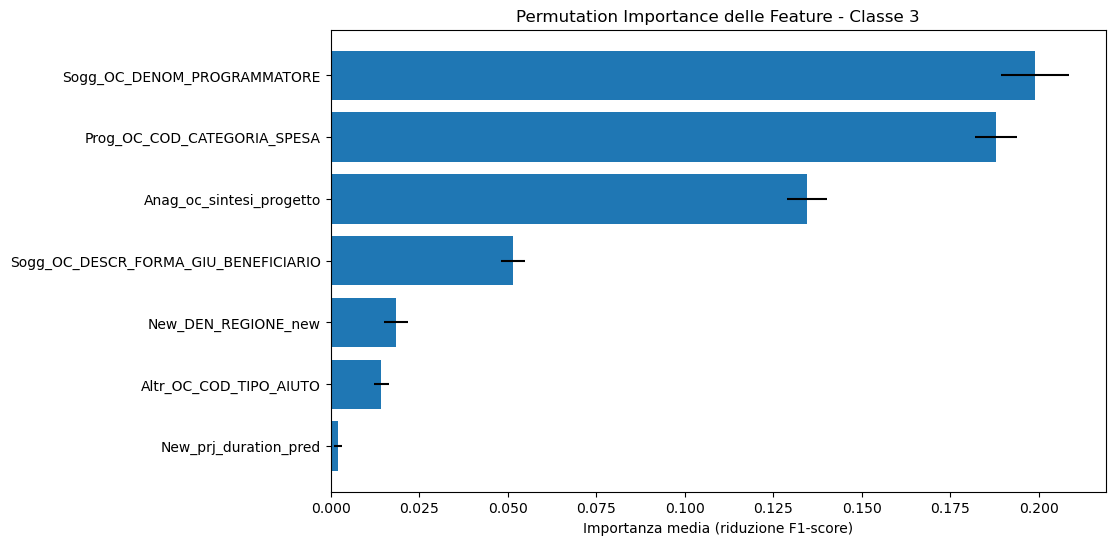

In [27]:
from sklearn.metrics import f1_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

#  Permutation Importance for each class
class_importances = {}

for i in range(n_classes):
    print(f"Calcolo Permutation Importance per Classe {i}")

    #
    y_binary = (y_test == i).astype(int)  

   
    def binary_f1_scorer(estimator, X, y):
        y_pred = estimator.predict(X)  
        y_binary_pred = (y_pred == i).astype(int)  
        return f1_score(y, y_binary_pred)  

    perm_importance = permutation_importance(
        best_model,
        X_test,
        y_binary,
        scoring=binary_f1_scorer,  
        random_state=42,
        n_repeats=10
    )

    class_importances[i] = perm_importance

    # Plot for class i
    feature_names = X_test.columns  
    importances = perm_importance.importances_mean
    std = perm_importance.importances_std
    sorted_idx = np.argsort(importances)[::-1] 

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_idx)), importances[sorted_idx], xerr=std[sorted_idx], align="center")
    plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
    plt.gca().invert_yaxis()  # Inverto l'asse per mostrare le più importanti in alto
    plt.title(f"Permutation Importance delle Feature - Classe {i}")
    plt.xlabel("Importanza media (riduzione F1-score)")
#    plt.savefig('Classe'+{i})
    plt.savefig(f"img/Permutation_Importance_Classe_{i}.png")
    plt.show()
